In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.metrics.pairwise import cosine_similarity

In this notebook, we use [marketing campaign](https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign) data to do a market segmentation for a wine company. We use demographic data to cluster customers and study their simnilarities and spending habits and better target them.

Observations:

We identified 5 clusters using DBSCAN: Cluster 0, Cluster 1, CLuster 2, Cluster 3, and Cluster 4. Some clusters are quite similar to each other while nearly opposite to others. We could then group them as follow:
* Clusters 2 and 3 share similarities in spending less on wine, having fewer Seniors, and having small children. The distinguishing factor is the education level---ehile Cluster 3 comprises only PhD customers, Cluster 2 includes Undergraduate and Master's level customers. This suggests that education might influence wine spending habits more than age or family composition in these clusters.
* Clusters 1 and 4 are characterized as bigger spenders on wine. They contrast significantly with Clusters 2 and 3 in terms of having more Seniors, higher income, and no small children. Cluster 4, in particular, spends more on wine than Cluster 1, likely due to the higher proportion of PhD customers.
* Cluster 0 doesn't exhibit clear trends and contains data points that might fit better in other clusters. It could be due to inconsistencies or noise in the data.

Insights:
* Education level might play a significant role in wine spending habits, potentially more than age or family composition in certain clusters.
* Seniors with higher income and no small children tend to spend more on wine, with the presence of PhD customers correlating with higher spending.
* The tendency of Seniors to spend more on wine could be a generation matter. It could be that older generation favor wine while young are more drawn towards beer and spirits.

## Preprocess Data

In [2]:
data = pd.read_csv("dataset/marketing_campaign.csv", sep="\t")
data.shape

(2240, 29)

In [5]:
def get_age_group(age):
    if age < 0:
        raise Error("Negative age is invalid")
    elif age <= 4:
        return "0-4"
    elif age <= 12:
        return "5-12"
    elif age <= 19:
        return "12-19"
    elif age <= 35:
        return "20-35"
    elif age <= 60:
        return "36-60"
    else:
        return "60+"
    
def get_age_group2(age):
    if age < 0:
        raise Error("Negative age is invalid")
    elif age <= 60:
        return "Adults"
    else:
        return "Seniors"
    
def get_generation(year):
    if year <= 1955:
        return "Baby Boomers & Older"
    elif year <= 1965:
        return "Generation X"
    elif year <= 2012:
        return "Millennials & Generation Z"
    else:
        return np.nan

In [6]:
def categorize_amount(amount):
    if amount < 0:
        raise Error("Negative amount")
    
    if amount == 0:
        return np.nan
    elif amount <= 40:
        return "0-40"
    elif amount <= 100:
        return "41-100"
    elif amount <= 300:
        return "101-300"
    elif amount <= 1000:
        return "301-1000"
    else:
        return "1000+"

In [87]:
def preprocess_data(data):
    # Select relevant columns
    columns = ["ID", "Year_Birth", "Education", "Income", "Kidhome", "MntWines"]
    df_clean = data[columns].copy()
    
    # Remove non spenders
    df_clean = df_clean[df_clean["MntWines"] > 0]
    # Extract and filter out age dead people
    df_clean["Customer_Age"] = 2019 - df_clean["Year_Birth"]
    df_clean = df_clean[df_clean["Customer_Age"] <= 80]
    # Add age groups
    df_clean["Generation"] = df_clean["Year_Birth"].apply(lambda x: get_generation(int(x)))
    df_clean["Age_Group"] = df_clean["Customer_Age"].apply(lambda x: get_age_group2(int(x)))
    # Ramove customers with Basic education
    df_clean = df_clean[df_clean["Education"] != "Basic"]
    df_clean["Education"] = df_clean["Education"].replace({
        "Graduation": "Undergraduate", "2n Cycle": "Master"
    })
    df_clean["Education2"] = df_clean["Education"].replace({
        "Graduation": "Undergraduate", "2n Cycle": "Advanced degree", 
        "Master": "Advanced degree", "PhD": "Advanced degree"
    })
    # Filter out income outliers
    df_clean = df_clean[df_clean["Income"] < 666666]
    # Make Kidhome binary
    df_clean["Kidhome"] = (df_clean["Kidhome"] > 0).astype(int)
    # Add amount group
    df_clean["Amount_Group"] = df_clean["MntWines"].apply(categorize_amount)
    cat_order = ["0-40", "41-100", "101-300", "301-1000", "1000+"]
    df_clean["Amount_Group"] = pd.Categorical(df_clean['Amount_Group'], categories=cat_order, ordered=True)
    # Remove income outliers
    income_outliers = indentify_outliers(df_clean["Income"].values)
    df_clean = df_clean[~df_clean["Income"].apply(lambda x: x in income_outliers)]
    
    return df_clean

In [88]:
def indentify_outliers(arr):
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)
    iqr = q3 - q1
    threshold = 1.5
    outliers = arr[(arr < q1 - threshold * iqr) | (arr > q3 + threshold * iqr)]
    return outliers

In [89]:
df_clean = preprocess_data(data)

In [90]:
df_clean.head()

,ID,Year_Birth,Education,Income,Kidhome,MntWines,Customer_Age,Generation,Age_Group,Education2,Amount_Group
0,5524,1957,Undergraduate,58138.0,0,635,62,Generation X,Seniors,Undergraduate,301-1000
1,2174,1954,Undergraduate,46344.0,1,11,65,Baby Boomers & Older,Seniors,Undergraduate,0-40
2,4141,1965,Undergraduate,71613.0,0,426,54,Generation X,Adults,Undergraduate,301-1000
3,6182,1984,Undergraduate,26646.0,1,11,35,Millennials & Generation Z,Adults,Undergraduate,0-40
4,5324,1981,PhD,58293.0,1,173,38,Millennials & Generation Z,Adults,Advanced degree,101-300


In [91]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2144 entries, 0 to 2239
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ID            2144 non-null   int64   
 1   Year_Birth    2144 non-null   int64   
 2   Education     2144 non-null   object  
 3   Income        2144 non-null   float64 
 4   Kidhome       2144 non-null   int32   
 5   MntWines      2144 non-null   int64   
 6   Customer_Age  2144 non-null   int64   
 7   Generation    2144 non-null   object  
 8   Age_Group     2144 non-null   object  
 9   Education2    2144 non-null   object  
 10  Amount_Group  2144 non-null   category
dtypes: category(1), float64(1), int32(1), int64(4), object(4)
memory usage: 178.2+ KB


## Clustering

In this section we test different clustering algorithms on our data to analyse different groups of customers.

In [92]:
features = ["Education", "Income", "Kidhome", "MntWines", "Customer_Age"]

In [93]:
X = df_clean[features]
X = pd.get_dummies(X, columns=["Education"])

In [94]:
X.shape

(2144, 7)

In [95]:
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[["Income", "MntWines", "Customer_Age"]] = scaler.fit_transform(X[["Income", "MntWines", "Customer_Age"]])

In [96]:
X_scaled.head()

,Income,Kidhome,MntWines,Customer_Age,Education_Master,Education_PhD,Education_Undergraduate
0,0.277164,0,0.946854,1.004448,0,0,1
1,-0.304791,1,-0.897743,1.262439,0,0,1
2,0.942065,0,0.329033,0.316472,0,0,1
3,-1.276756,1,-0.897743,-1.317471,0,0,1
4,0.284812,1,-0.418857,-1.059480,0,1,0


In [97]:
tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto')
reduced_data = tsne.fit_transform(X_scaled)

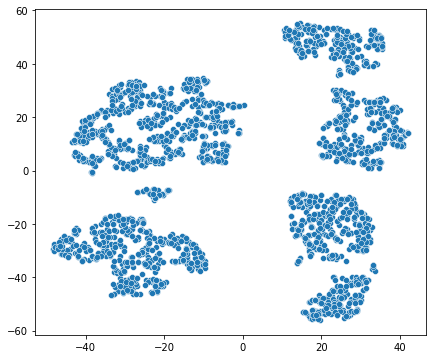

In [204]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1])
plt.savefig("tnse_clusters.png")

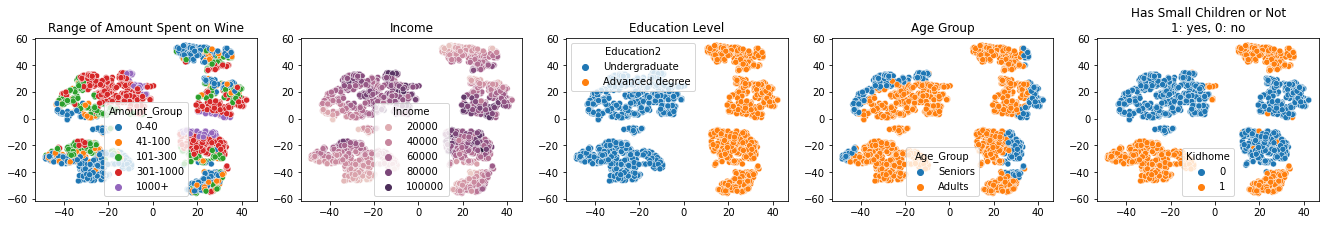

In [102]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(23,3))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df_clean["Amount_Group"], ax=ax[0], palette='tab10')
ax[0].set_title("Range of Amount Spent on Wine")
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df_clean["Income"], ax=ax[1])
ax[1].set_title("Income")
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df_clean["Education2"], ax=ax[2], palette='tab10')
ax[2].set_title("Education Level")
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df_clean["Age_Group"], ax=ax[3], palette='tab10')
ax[3].set_title("Age Group")
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df_clean["Kidhome"], ax=ax[4], palette='tab10')
ax[4].set_title("Has Small Children or Not\n1: yes, 0: no")
plt.show()

### KMeans

In [112]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_scaled)
kmeans_clusters = kmeans.predict(X_scaled)

C:\Users\ngoum\anaconda3\envs\dl-env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


In [113]:
np.unique(kmeans_clusters)

array([0, 1, 2, 3, 4])

<AxesSubplot:>

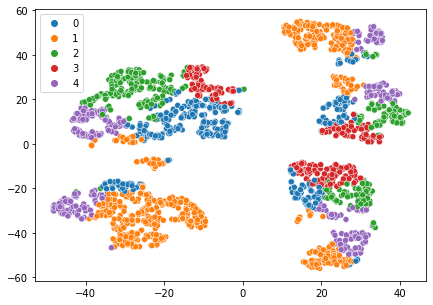

In [114]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=kmeans_clusters, palette='tab10')

### Mean Shift

In [121]:
mean_shift = MeanShift(bandwidth=1.42)
mean_shift_clusters = mean_shift.fit_predict(X_scaled)
np.unique(mean_shift_clusters)

array([0, 1, 2, 3], dtype=int64)

<AxesSubplot:>

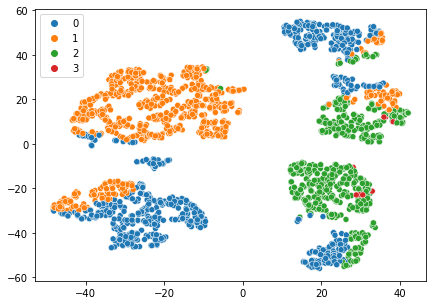

In [122]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=mean_shift_clusters, palette='tab10')

### DBSCAN

In [123]:
dbscan = DBSCAN(eps=1.3, min_samples=5)
dbscan_clusters = dbscan.fit_predict(X_scaled)
np.unique(dbscan_clusters)

array([-1,  0,  1,  2], dtype=int64)

In [124]:
dbscan_clusters += 1

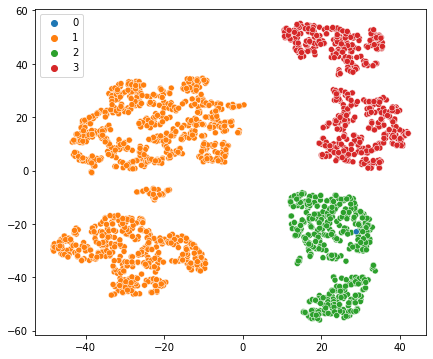

In [212]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=dbscan_clusters, palette='tab10')
plt.savefig("dbscan_with_education.png")

## Analysis

* `cluster-2` and `cluster-3` are very similar based on certain factors. They both tend to spend less on wine than other clusters, they're composed of less Senior customers, and they have small children. The difference between the two clusters lies in the education level. While `cluster-3` are only PhD customers, `cluster-2` includes Undergraduate and Master's level only.
* `cluster-1` and `cluster-4` are the biggest spenders when it comes to wine. The two clusters are fairly similar to each other and nearly opposed to the two previous clusters (`cluster-2` and `cluster-3)`. They have a higher percentage of `Seniors` (~50% more than `cluster-3` and 99% more than `cluster-2`), have an higher income (on average) and do not have small children. We should not that customers in `cluster-4` tend to spend more than those in `cluster-1`. This could be due to the higher number of PhD customers in that cluster.
* `cluster-0` appears to be an outlier and contains datapoints that should've been included in other clusters. It doesn't show clear trends.

### `clusters`

DBSCAN split the data points into 5 clusters. `cluster-0` is the smallest of all and could be an outlier. The most numerous clusters are `cluster-1` and `cluster-2`.

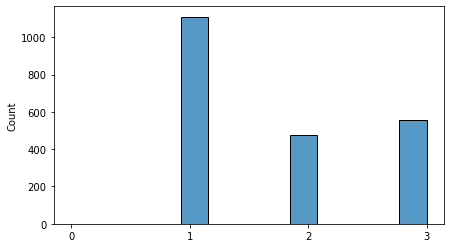

In [140]:
plt.figure(figsize=(7,4))
sns.histplot(x=dbscan_clusters)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=4))

### `MntWines`

* On avergae, customers in `cluster-2` and `cluster-3` spend the lowest amount on wine while `cluster-4` spends the most on average. When it comes to `cluster-0`, the number of data points is significantly smaller so the variance is higher.
* Based on this observation, the least profitable customers would be those in `cluster-2`, and `clsuter-3`.

In [141]:
pd.Series(dbscan_clusters).value_counts()

1    1110
3     558
2     475
0       1
dtype: int64

<AxesSubplot:ylabel='MntWines'>

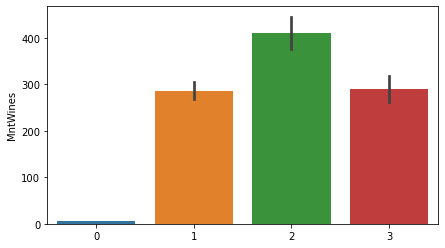

In [142]:
plt.figure(figsize=(7,4))
sns.barplot(x=dbscan_clusters, y=df_clean["MntWines"], palette='tab10')

<AxesSubplot:xlabel='MntWines', ylabel='Percent'>

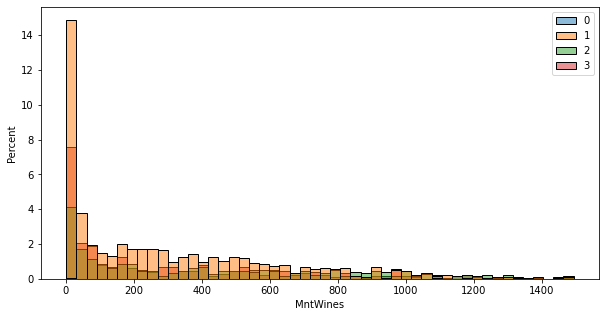

In [180]:
plt.figure(figsize=(10,5))
sns.histplot(data=df_clean, x='MntWines', bins=50, stat='percent', hue=dbscan_clusters, palette='tab10')

### `Amount_Group`

* Here, `cluster-2` and very similar to `cluster-4`. They both tend to spend less on wine than other clusters.
* `cluster-1` and `cluster-4` also share some similarities but a little less. They tend to spend more on wine than the previous two clusters.
* `cluster-0` doesn't show a clear trend and pretty much includes everything.

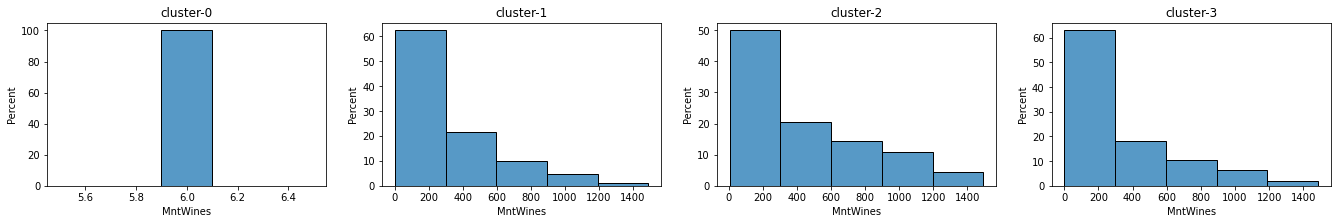

In [177]:
fig,ax = plt.subplots(ncols=4, nrows=1, figsize=(23,3))
for i,cluster in enumerate(np.unique(dbscan_clusters)):
    sns.histplot(data=df_clean[dbscan_clusters==cluster], x='MntWines', bins=5, stat='percent', palette='tab10', ax=ax[i])
    ax[i].set_title(f"cluster-{cluster}")

<AxesSubplot:xlabel='Amount_Group', ylabel='Count'>

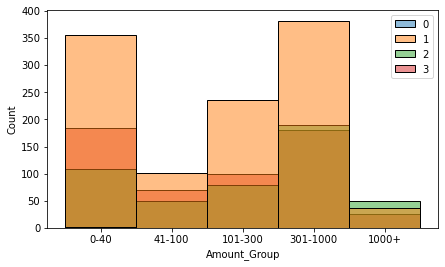

In [149]:
plt.figure(figsize=(7,4))
sns.histplot(data=df_clean, x='Amount_Group', bins=50, hue=dbscan_clusters, palette='tab10')

### `Education`

* All of the clusters are homogeneous when it comes to education level except `cluster-0` that has both `PhD` and `Undergraduate & Master`.
* `cluster-1` and `cluster-2` are composed of customers with undergraduate or master's level of education while `cluster-3` and `cluster-4` are PhDs.

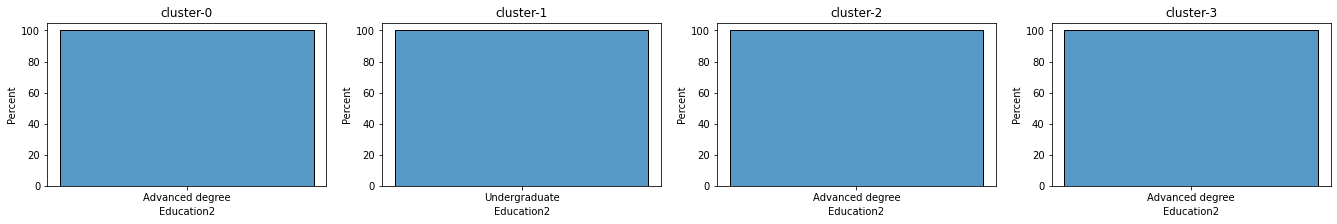

In [151]:
fig,ax = plt.subplots(ncols=4, nrows=1, figsize=(23,3))
for i,cluster in enumerate(np.unique(dbscan_clusters)):
    sns.histplot(data=df_clean[dbscan_clusters==cluster], x='Education2', bins=5, stat='percent', palette='tab10', ax=ax[i])
    ax[i].set_title(f"cluster-{cluster}")

### `Age_Group`

* All of the clusters have a combinaison of all age groups. Overall, there are more `Adults` than `Seniors` in clusters, which reflects the distribution in the original data and also US population.
* There is a slight trend with `cluster-1` and `cluster-4` who has a higher percentage of `Seniors`.
* `cluster-0` stands out with an nearly equal amount of `Seniors` and `Adults`.

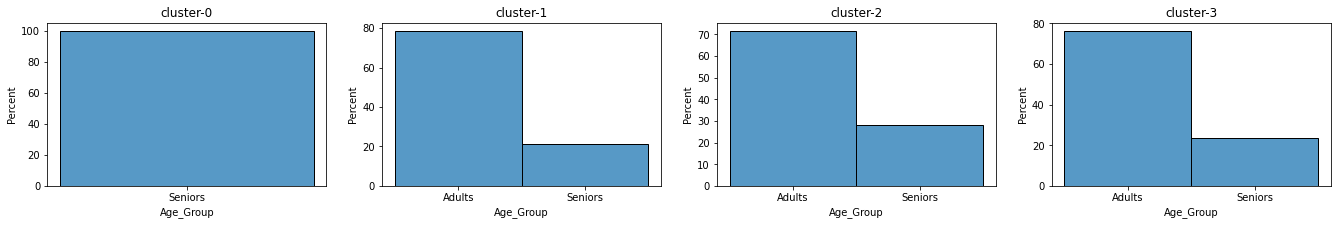

In [152]:
fig,ax = plt.subplots(ncols=4, nrows=1, figsize=(23,3))
for i,cluster in enumerate(np.unique(dbscan_clusters)):
    sns.histplot(data=df_clean[dbscan_clusters==cluster].sort_values(by="Age_Group"), x='Age_Group', bins=5, stat='percent', palette='tab10', ax=ax[i])
    ax[i].set_title(f"cluster-{cluster}")

### `Kidhome`

* `cluster-1` and `cluster-4` are very similar as they do not have small children. On the other end, `cluster-2` and `cluster-3` have small children.
* Here also, `cluster-0` stands out by not showing a trend.

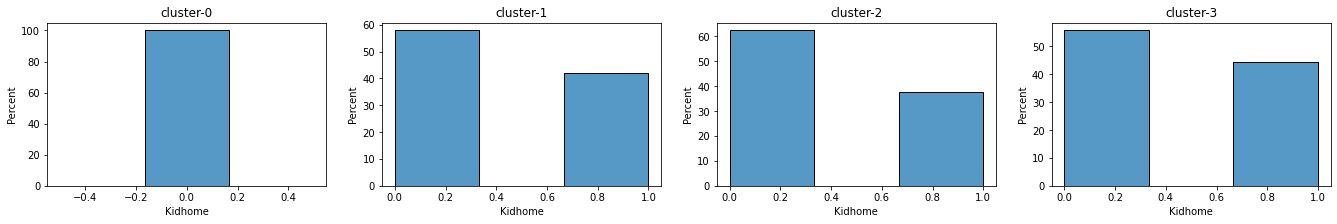

In [161]:
fig,ax = plt.subplots(ncols=4, nrows=1, figsize=(23,3))
for i,cluster in enumerate(np.unique(dbscan_clusters)):
    sns.histplot(data=df_clean[dbscan_clusters==cluster], x='Kidhome', bins=3, stat='percent', palette='tab10', ax=ax[i])
    ax[i].set_title(f"cluster-{cluster}")

### `Income`

* `cluster-1` and `cluster-4` tend to have higher income compared to `cluster-2` and `cluster-3`
* `cluster-0` has a wider range of income and includes customers with the highest annual income in the dataset.

<AxesSubplot:ylabel='Income'>

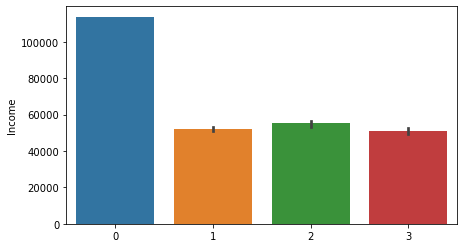

In [162]:
plt.figure(figsize=(7,4))
sns.barplot(x=dbscan_clusters, y=df_clean["Income"], palette='tab10')

<AxesSubplot:xlabel='Income', ylabel='Percent'>

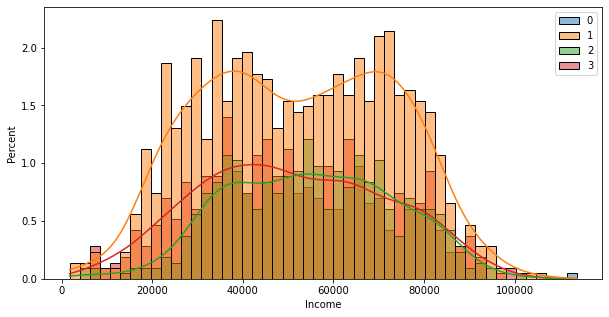

In [163]:
plt.figure(figsize=(10,5))
sns.histplot(data=df_clean, x='Income', bins=50, stat='percent', kde=True, hue=dbscan_clusters, palette='tab10')

As `Education` is the main difference between similar clusters, let's remove it from our features and observe the new clusters.

In [164]:
features2 = ["Income", "Kidhome", "MntWines", "Customer_Age"]
X2 = df_clean[features2]
scaler = StandardScaler()
X2_scaled = X2.copy()
X2_scaled[["Income", "MntWines", "Customer_Age"]] = scaler.fit_transform(X2[["Income", "MntWines", "Customer_Age"]])

In [165]:
tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto')
reduced_data2 = tsne.fit_transform(X2_scaled)

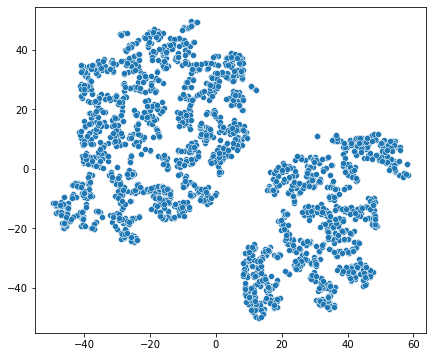

In [214]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=reduced_data2[:, 0], y=reduced_data2[:, 1])
plt.savefig("tnse_clusters_no_education.png")

In [167]:
dbscan = DBSCAN(eps=1.0, min_samples=5)
dbscan_clusters2 = dbscan.fit_predict(X2_scaled)
np.unique(dbscan_clusters2)

array([-1,  0,  1], dtype=int64)

In [206]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X2_scaled)
kmeans_clusters = kmeans.predict(X2_scaled)

C:\Users\ngoum\anaconda3\envs\dl-env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


In [168]:
dbscan_clusters2 += 1

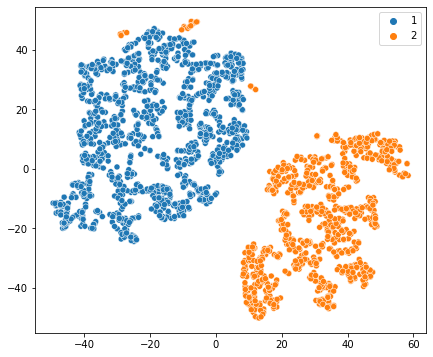

In [210]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=reduced_data2[:, 0], y=reduced_data2[:, 1], hue=dbscan_clusters2, palette='tab10')
plt.savefig("dbscan_no_education.png")

In [173]:
pd.Series(dbscan_clusters2).value_counts()

1    1249
2     893
0       2
dtype: int64

In [174]:
dbscan_clusters2[dbscan_clusters2 == 0] = 1

In [ ]:
df_clean["cluster"] = dbscan_clusters2

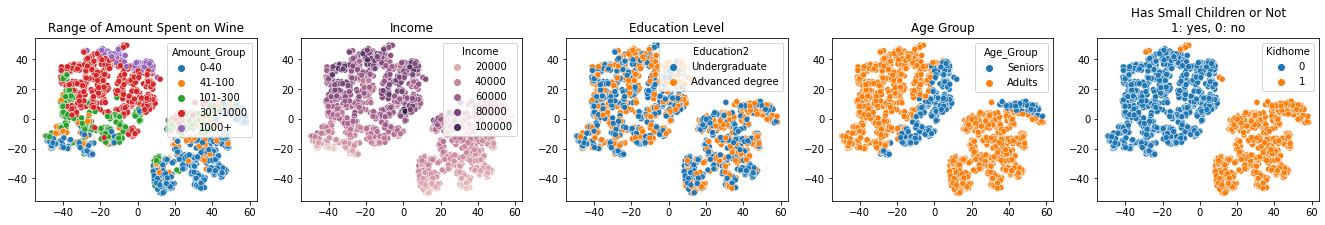

In [175]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(23,3))
sns.scatterplot(x=reduced_data2[:, 0], y=reduced_data2[:, 1], hue=df_clean["Amount_Group"], ax=ax[0], palette='tab10')
ax[0].set_title("Range of Amount Spent on Wine")
sns.scatterplot(x=reduced_data2[:, 0], y=reduced_data2[:, 1], hue=df_clean["Income"], ax=ax[1])
ax[1].set_title("Income")
sns.scatterplot(x=reduced_data2[:, 0], y=reduced_data2[:, 1], hue=df_clean["Education2"], ax=ax[2], palette='tab10')
ax[2].set_title("Education Level")
sns.scatterplot(x=reduced_data2[:, 0], y=reduced_data2[:, 1], hue=df_clean["Age_Group"], ax=ax[3], palette='tab10')
ax[3].set_title("Age Group")
sns.scatterplot(x=reduced_data2[:, 0], y=reduced_data2[:, 1], hue=df_clean["Kidhome"], ax=ax[4], palette='tab10')
ax[4].set_title("Has Small Children or Not\n1: yes, 0: no")
plt.show()

<AxesSubplot:ylabel='MntWines'>

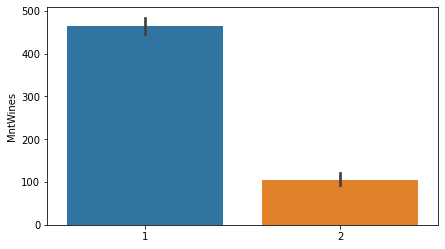

In [176]:
plt.figure(figsize=(7,4))
sns.barplot(x=dbscan_clusters2, y=df_clean["MntWines"], palette='tab10')

In [234]:
df_clean[["cluster", "Income"]].groupby(["cluster"]).mean()

,Income
cluster,
1,62264.90008
2,38870.68533


<AxesSubplot:xlabel='MntWines', ylabel='Count'>

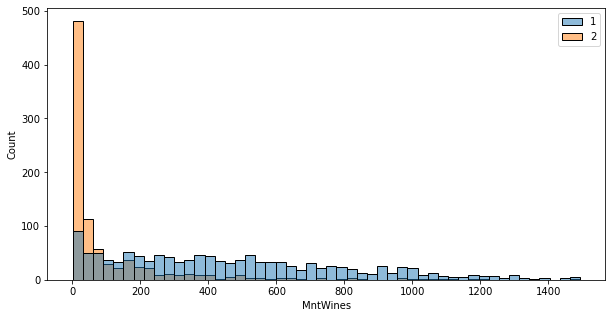

In [193]:
plt.figure(figsize=(10,5))
sns.histplot(data=df_clean, x='MntWines', bins=50, hue=dbscan_clusters2, palette='tab10')

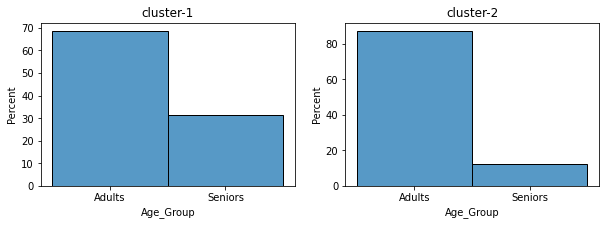

In [185]:
fig,ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
for i,cluster in enumerate(np.unique(dbscan_clusters2)):
    sns.histplot(data=df_clean[dbscan_clusters2==cluster].sort_values(by="Age_Group"), x='Age_Group', bins=5, stat='percent', palette='tab10', ax=ax[i])
    ax[i].set_title(f"cluster-{cluster}")

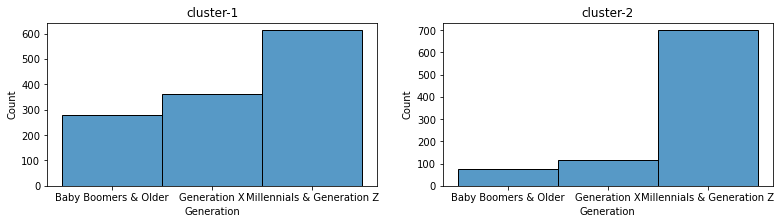

In [200]:
fig,ax = plt.subplots(ncols=2, nrows=1, figsize=(13,3))
for i,cluster in enumerate(np.unique(dbscan_clusters2)):
    sns.histplot(data=df_clean[dbscan_clusters2==cluster].sort_values(by="Generation"), x='Generation', bins=5, palette='tab10', ax=ax[i])
    ax[i].set_title(f"cluster-{cluster}")

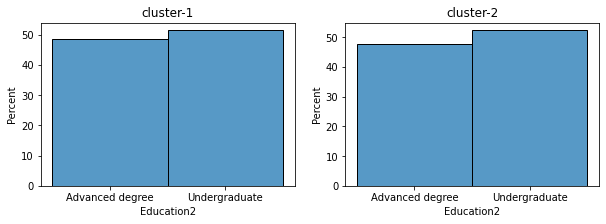

In [190]:
fig,ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
for i,cluster in enumerate(np.unique(dbscan_clusters2)):
    sns.histplot(data=df_clean[dbscan_clusters2==cluster].sort_values(by="Education2"), x='Education2', bins=5, stat='percent', palette='tab10', ax=ax[i])
    ax[i].set_title(f"cluster-{cluster}")

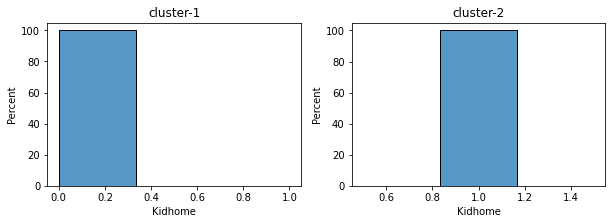

In [186]:
fig,ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
for i,cluster in enumerate(np.unique(dbscan_clusters2)):
    sns.histplot(data=df_clean[dbscan_clusters2==cluster], x='Kidhome', bins=3, stat='percent', palette='tab10', ax=ax[i])
    ax[i].set_title(f"cluster-{cluster}")

<AxesSubplot:ylabel='Income'>

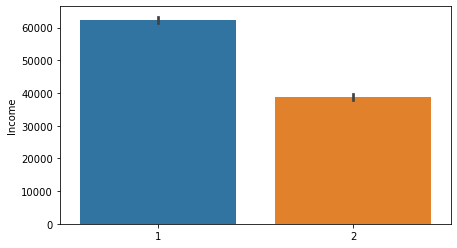

In [187]:
plt.figure(figsize=(7,4))
sns.barplot(x=dbscan_clusters2, y=df_clean["Income"], palette='tab10')

<AxesSubplot:xlabel='Income', ylabel='Percent'>

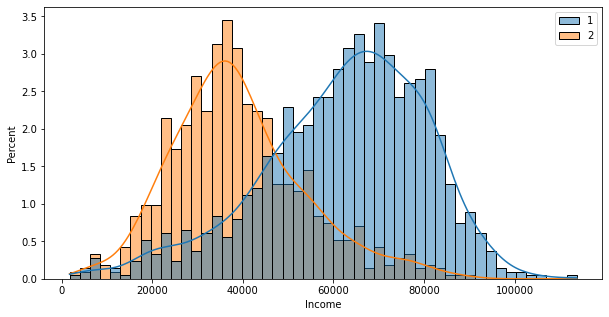

In [188]:
plt.figure(figsize=(10,5))
sns.histplot(data=df_clean, x='Income', bins=50, stat='percent', kde=True, hue=dbscan_clusters2, palette='tab10')